# LinkNet: Network for Semantic Segmentation

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

LinkNet architecture is inspired by auto-encoders: each encoder (decoder) perform downsampling (upsampling) the feature maps by a factor of 2. At the same time the number of channels increases (decreases) except the outputs of the first encoder-decoder blocks. The main novelty of LinkNet as a segmenation network is a usage of skip connections between encoders and decoders. This
approach enables to save spatial information that contains in input image and helps to learn neural networks. Each convolutional layer is followed by batch-normalization and ReLU. 

<img src='./pic/01.PNG' width="400" height="300">

<img src='pic/02.PNG' width="1000" height="400">

We will use LinkNet to segmenation of $128 \times 128$ images with MNIST $28 \times 28$ at random place (uniformly sampled) with noise generated on the base of MNIST fragments. Each fragment is randomly cutted from random image and is rotated by an angle $ \sim U(0,360^{\circ})$. Coordinates of top-left corner are sampled from uniform $U(0, 128-s)$ or normal $N\left(\frac{128-s}{2}, \left(\frac{128-s}{4}\right)^2\right)$ distribution where $s$ is equal to width (height) of rotated image.

In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append("..")
from dataset import Pipeline, DatasetIndex, Dataset

from linknet_model import LinkNetModel         # TFModel subclass with LinkNet
from nmnist import NoisedMnist                 # Batch subclass with loading and noise generating actions
from plot_functions import plot_examples       # plot functions to demonstrate result 

Fix constants to generate noised images and train LinkNet:

In [14]:
IMAGE_SIZE = 128     # image size
MNIST_SIZE = 65000   # MNIST database size
BATCH_SIZE = 512     # batch size for NN training
MAX_ITER = 2       # number of iterations for NN training

Define noise parameters:

In [15]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 60    # number of noise fragments per image  
size = 8            # size of noise fragment; 1, ..., 27
distr = 'normal'    # distribution of fragments of image; 'uniform' or 'normal'

Create DatasetIndex and Dataset to use pipelines:

In [16]:
ind = DatasetIndex(np.arange(MNIST_SIZE))          # create index for images
mnistset = Dataset(ind, batch_class=NoisedMnist)   # create Dataset for images with transform actions in NoisedMnist class
mnistset.cv_split([0.9, 0.1])                      # divide it into train and test

Сreate Pipeline template for image loading and transformation

In [17]:
load_template = (Pipeline()
                 .load_images()                    # load MNIST images from file
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .create_mask()                    # create mask for MNIST image location
                 .create_noise('mnist_noise',      # 'mnist_noise'- MNIST-based noise, 'random_noise' - uniform noise
                            level,
                            n_fragments, 
                            size, 
                            distr))

Plot some examples of noised images:

In [ ]:
def plot_noised_images(images, noise):
    

In [30]:
im.shape

(3, 128, 128)

In [28]:
images = []
noise = []
(load_template << mnistset.train).get_images(images).get_noise(noise).next_batch(5, shuffle=True)

images = images[0]
noise = noise[0]

im = np.stack((images[0],)*3)

plt.imshow(im)
plt.show()

TypeError: Invalid dimensions for image data

Create feed_dict's for TFModel. 
* '<b>image</b>' - name of input placeholdes described in TFModel
* '<b>images</b>' - name of attribute in NoisedMnist class
* '<b>mask</b>' - name of target placeholdes described in TFModel
* '<b>masks</b>' - name of attribute in NoisedMnist class
* '<b>mode</b>' - name of placeholdes for batch normalization training parameter 

In [18]:
train_feed_dict = {'image': 'images',
                  'mask': 'masks',
                  'mode': True}        

test_feed_dict = {'image': 'images',
                  'mask': 'masks',
                  'mode': False}

Create train and test pipelines:

In [19]:
ppl_train = ((load_template << mnistset.train)
            .add_noise()
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        LinkNetModel,                                      # TFModel subclass with LinkNet
                        'linknet',                                         # model name
                        config={'loss': 'sigmoid_cross_entropy',
                                'optimizer': 'Adam',
                                'image_size': IMAGE_SIZE})
            .train_model('linknet',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,                        
                         append_to='train_loss_history'))                  # name of pipeline variable to save loss value

ppl_test = ((load_template << mnistset.test)
            .add_noise()
            .import_model('linknet', ppl_train)
            .init_variable('predictions', init_on_each_run=list)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet',                                      
                           fetches='predicted_prob',
                           feed_dict=test_feed_dict,
                           append_to='predictions')
            .predict_model('linknet', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           append_to='test_loss_history'))

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [20]:
# training of the model

start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)                              # training step
    ppl_test.next_batch(100, n_epochs=None)                                      # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]                # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]                   # get current iteration test loss
    
    if (i+1) % 1 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, train_loss, test_loss))
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Iter   1: train 1.424 test 1.407
Iter   2: train 1.387 test 1.378
Train time: 0.226 min


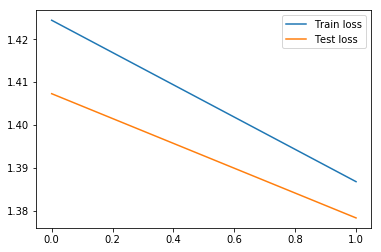

In [21]:
# plot train and test loss

plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_train.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

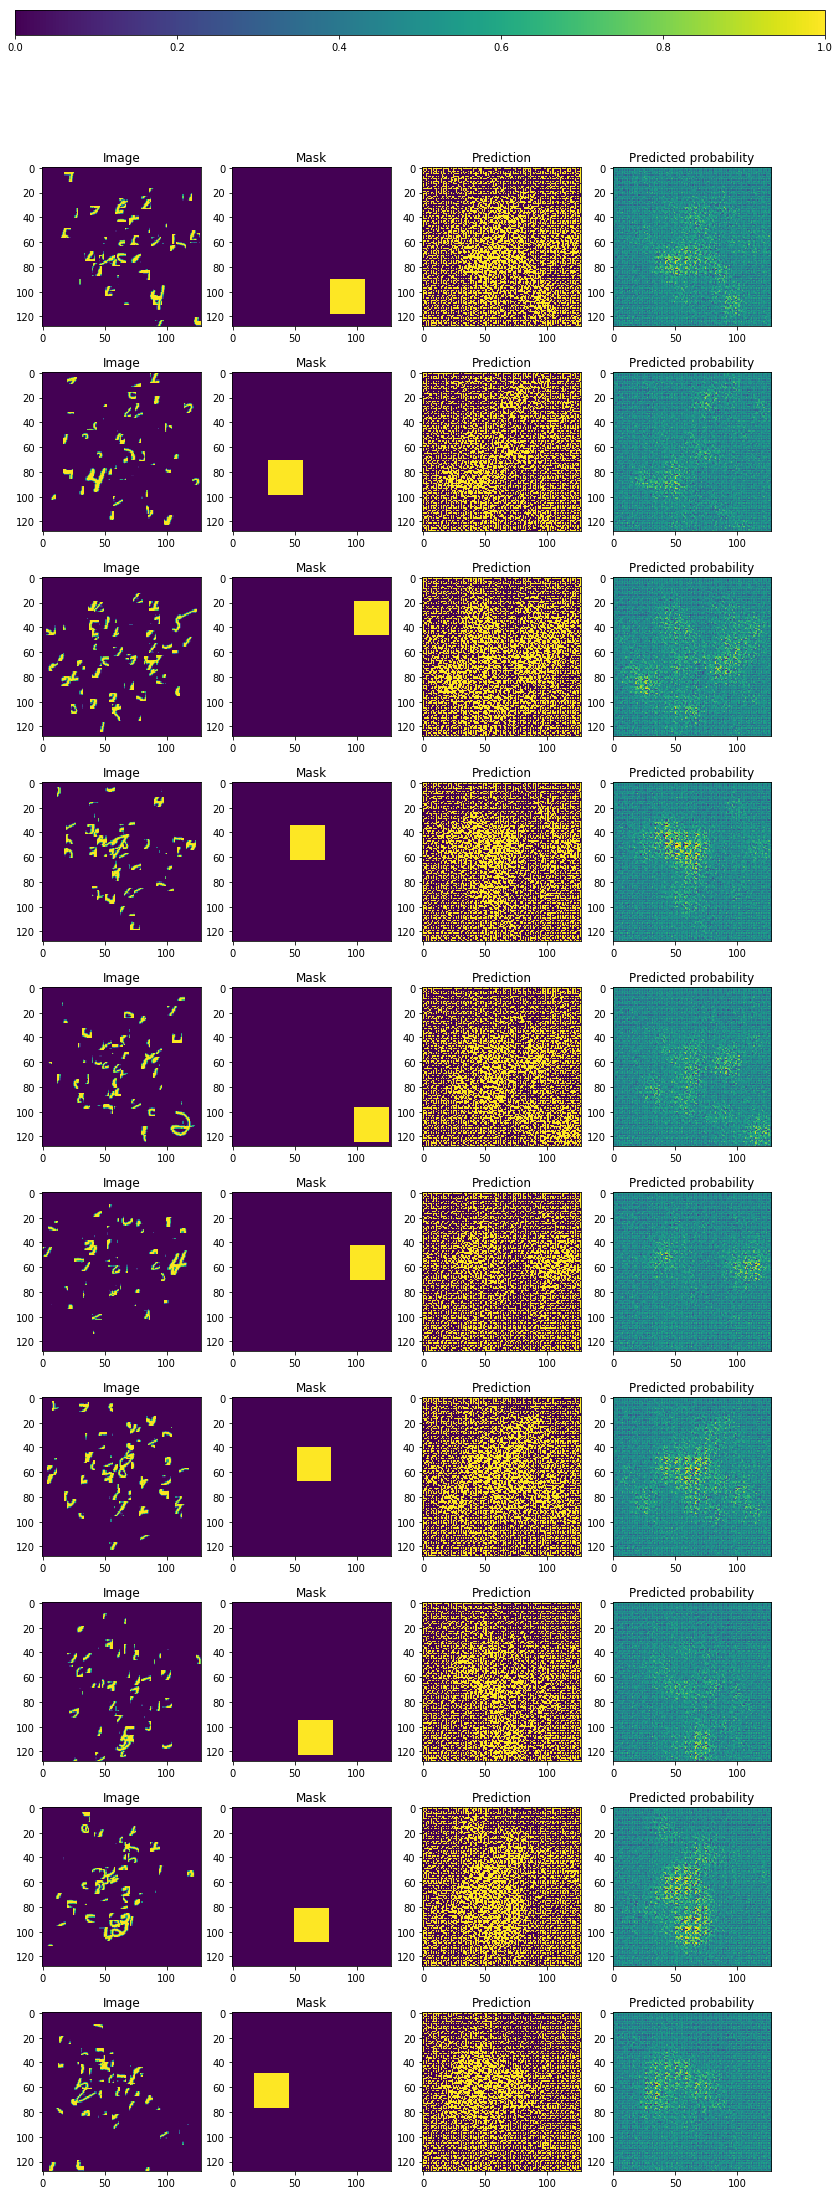

In [22]:
# get 10 images from test and corresponding masks predictions

images = []
masks = []
ppl_test.get_images(images).get_masks(masks).next_batch(10, n_epochs=None)
predictions = ppl_test.get_variable('predictions')[-1]

# plot them

plot_examples(images, masks, predictions)